Based off the lucid tensorflow 2d Neural style transfer example found here: https://github.com/tensorflow/lucid

The original example provided there no longer works, but I found a solution so I am reuploading it. All credits to lucid team. 


In [1]:
# Imports
!pip install lucid>=0.2.3
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf                                            
from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
from lucid.optvis.objectives import wrap_objective
tf.test.is_gpu_available()

model = vision_models.InceptionV1()
model.load_graphdef()
model.layers
print("finished.. continue to next code box")


TensorFlow 1.x selected.


W1019 19:13:46.336534 140230885087104 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/writing.py:62: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W1019 19:13:46.339214 140230885087104 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/writing.py:70: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W1019 19:13:47.550103 140230885087104 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/loading.py:72: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



finished.. continue to next code box


In [2]:
tf.test.is_gpu_available()

True

In [3]:
!git clone https://github.com/lutherrr/Lucid-NeuralStyleTransfer.git

Cloning into 'Lucid-NeuralStyleTransfer'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 35 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.


((600, 600, 3), (600, 600, 3))



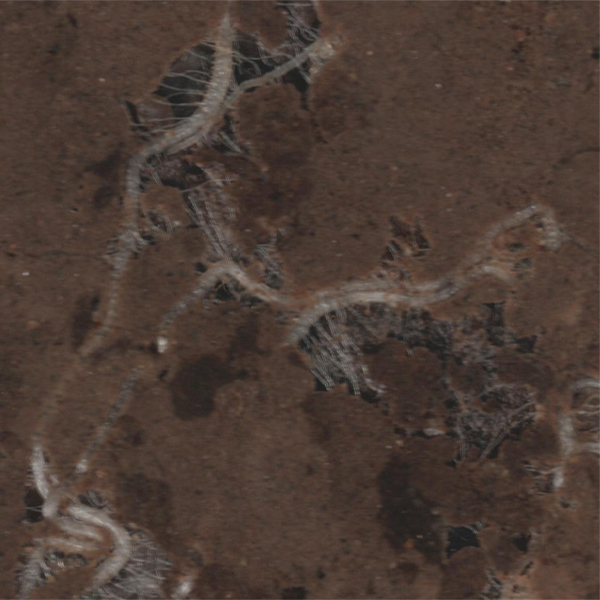


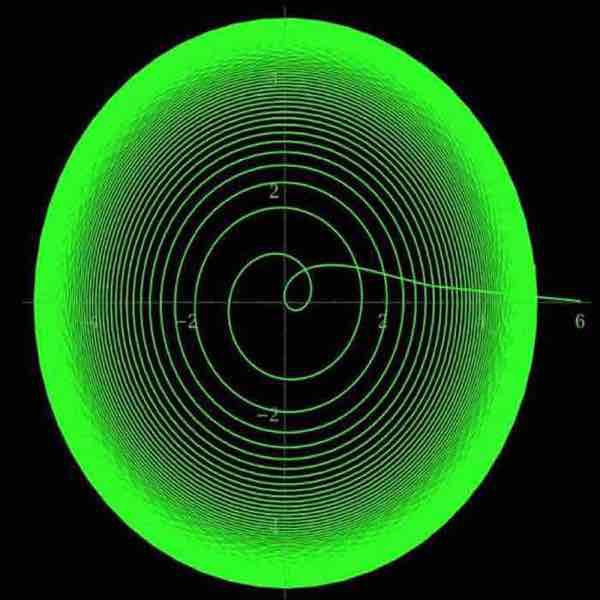

finished.. continue to next code box


In [4]:
from google.colab import files


content_image = load("/content/Lucid-NeuralStyleTransfer/images/root8.jpg")[..., :3]
style_image = load("//content/Lucid-NeuralStyleTransfer/images/GREEN600.jpg")[..., :3] 
print(content_image.shape, style_image.shape)

show(content_image)
show(style_image)
print("finished.. continue to next code box")


In [5]:
style_layers = [
  'conv2d2',
  'mixed3a',
  'mixed4a',
  'mixed4b',
  'mixed4c',
]

content_layers = [
  'mixed3b',
]

In [6]:
def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2

In [7]:
style_transfer_param(content_image, style_image).shape

W1019 19:16:14.158812 140230885087104 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/param/spatial.py:54: The name tf.spectral.irfft2d is deprecated. Please use tf.signal.irfft2d instead.



TensorShape([Dimension(3), Dimension(600), Dimension(600), Dimension(3)])

In [8]:
def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

In [9]:
@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]

    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]

    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses)

  return inner

In [10]:
def gram_matrix(array, normalize_magnitue=True):
  channels = tf.shape(array)[-1]
  array_flat = tf.reshape(array, [-1, channels])
  gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
  if normalize_magnitue:
    length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
  return gram_matrix

Now we have all the ingredients to set up an optimization in lucid: we will create two activation_difference objectives, a normal one for the content loss, and one transforming the activations using gram_matrix for the style loss.

In [11]:
param_f = lambda: style_transfer_param(content_image, style_image)

content_obj = 100 * activation_difference(content_layers, difference_to=CONTENT_INDEX)
content_obj.description = "Content Loss"

style_obj = activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
style_obj.description = "Style Loss"

objective = - content_obj - style_obj

vis = render.render_vis(model, objective, param_f=param_f, thresholds=[512], verbose=False, print_objectives=[content_obj, style_obj])[-1]

W1019 19:17:39.125471 140230885087104 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:88: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1019 19:17:39.362071 140230885087104 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:223: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1019 19:17:39.363755 140230885087104 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:241: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W1019 19:17:39.367851 140230885087104 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:169: The name tf.train.get_or_create_global_step is deprecated. Please use tf.compat.v1.train.get_or_create_global_step instead.

W1019 19:17:39.377428 140230885087104 module_wrapper.py:139] From /us


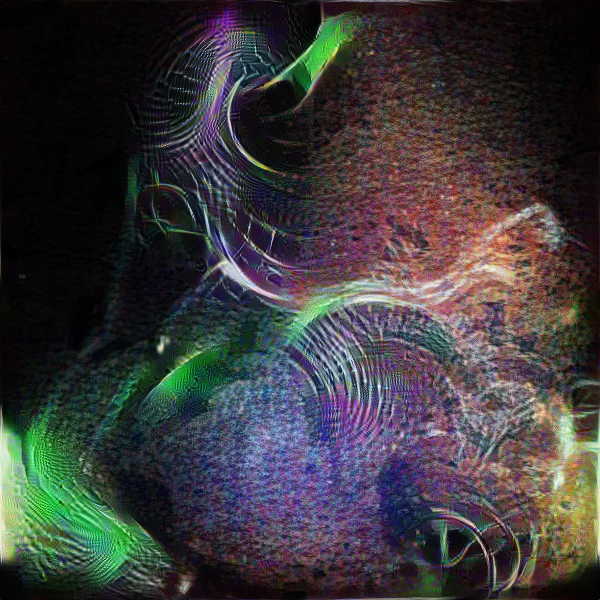
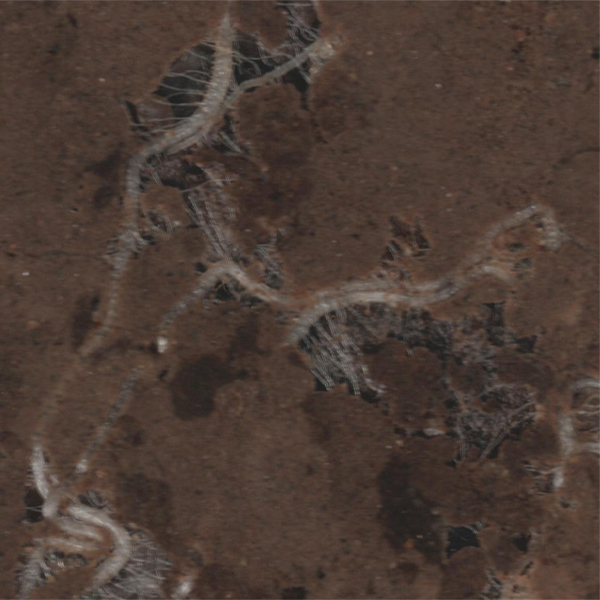
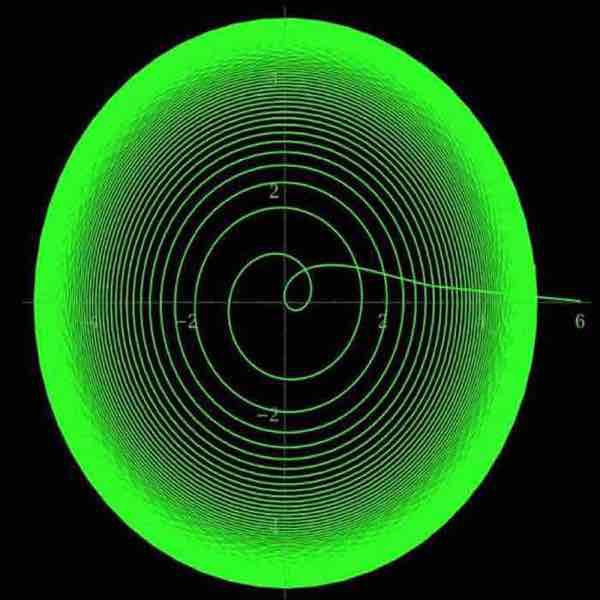

In [12]:
show(vis)

The influence of parameterization & transformation robustness. In the last rendering, we already used one of our differentiable parameterizations: a color decorrelated image in frequency space:

In [13]:
param_f = lambda: param.image(width, height, decorrelate=True, fft=True)

(This parameterization has turned out to be so useful and stable that the last two arguments default to True in lucid. If you want to learn more, we describe it in Feature Visualization, and the module lucid.optvis.param.spatial contains our implementation "fft_image()".)

We also—implicitly—used the default robustness transforms built into lucid.

# Parameterization

It turns out that this parameterization is really important! Let's compare what happens when we try without these paramterizations first:

In [ ]:
param_f = lambda: style_transfer_param(content_image, style_image, decorrelate=False, fft=False)

bad_param_vis = render.render_vis(model, objective, param_f, verbose=True, thresholds=(25, 75, 150, 300, 512), print_objectives=[content_obj, style_obj])[-1]


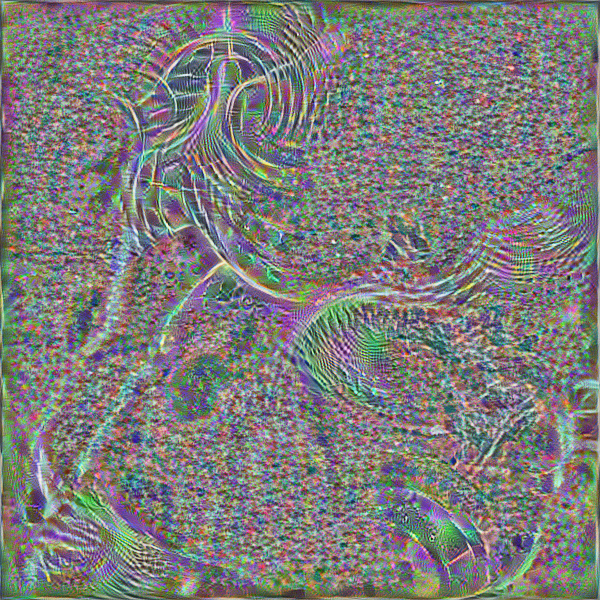

In [15]:
show(bad_param_vis[0])

# Transformation robustness

In [ ]:
param_f = lambda: style_transfer_param(content_image, style_image, decorrelate=False, fft=False)

transforms = [] # specifying an empty array overrides default transformations

no_transforms_vis = render.render_vis(model, objective, param_f, transforms=transforms, verbose=True, thresholds=(25, 75, 150, 300, 512), print_objectives=[content_obj, style_obj])[-1]


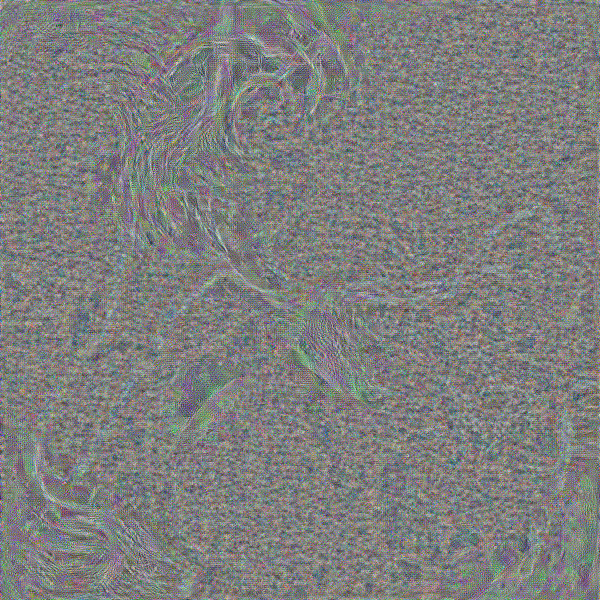

In [17]:
show(no_transforms_vis[0])

While these results still contains characteristics from both source images, you can tell that the optimization process has a much harder time getting to a good result. The resulting image is affected by checkerboard artefacts. We wrote about transformation robustness in Feature Visualization and about (at least one of the) underlying causes in Checkerboard Artefacts.


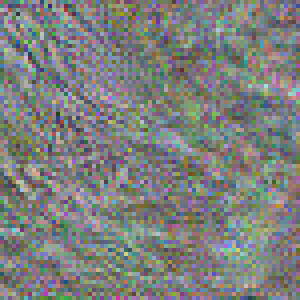

In [18]:
detail = no_transforms_vis[0][-75:, 125:200, ...] # just a manually selected part of the above visualization
zoomed4x = np.kron(detail, np.ones((4,4,1)))
show(zoomed4x)